# Required Installation and Library

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4498211 sha256=ab725259e620d54dbd7d050619c0c64e39c802560a366e18ca35ce610dc89bae
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext


In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import pandas as pd
from datasets import Dataset, load_dataset

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, f1_score, precision_score, recall_score)
from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    pipeline,
    AutoModelForSequenceClassification
)

from collections import Counter
from datasets import Dataset
import fasttext

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
%cd drive/MyDrive/RequiredFiles

/content/drive/MyDrive/RequiredFiles


In [ ]:
# loading fasttext khmer word embedding model
embedding_model = fasttext.load_model('cc.km.300.bin')

In [ ]:
# import os
# os.environ['OMP_NUM_THREADS'] = '1'
# os.environ['TOKENIZERS_PARALLELISM'] = 'false'
# # loading fasttext khmer word embedding model
# try:
#     embedding_model = fasttext.load_model('cc.km.300.bin')
# except Exception as e:
#     raise RuntimeError(f'Failed to load FastText model: {e}')

In [ ]:
df = pd.read_csv("train_data.csv", encoding="utf-8-sig")
df.head(5)

X = df[[
            'oov_ratio',
            'dep_grammar_score',
            'has_complete_clause',
            'sentence_length',
            'avg_word_length',
            'char_per_word',
            'semantic_coherence',
            'grammar_oov_interaction'
        ]]

y = df['sentence_correct']

# Split data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Train set: 12063 samples
Validation set: 4021 samples
Test set: 4022 samples


In [ ]:
X_test.tail()

,oov_ratio,dep_grammar_score,has_complete_clause,sentence_length,avg_word_length,char_per_word,semantic_coherence,grammar_oov_interaction
7216,0.058824,1.0,1,17,4.705882,4.705882,0.210457,0.941176
20075,0.208333,1.0,1,24,5.333333,5.333333,0.220237,0.791667
11431,0.133333,1.0,1,30,4.333333,4.333333,0.170317,0.866667
14751,0.209302,1.0,1,43,6.302326,6.302326,0.202020,0.790698
12189,0.071429,1.0,1,28,5.285714,5.285714,0.268315,0.928571


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import numpy as np

class KhmerTextDataset(Dataset):
    """
    Dataset for GRU training using FastText embeddings with caching.

    Caches embeddings per unique token to avoid repeated FastText lookups.
    """
    # Class-level cache shared across all instances
    _embedding_cache = {}

    def __init__(self, tokens_list, labels, embedding_model, use_cache=True):
        self.tokens_list = tokens_list
        self.labels = labels
        self.embedding_model = embedding_model
        self.embedding_dim = embedding_model.get_dimension()
        self.use_cache = use_cache

        # Pre-cache embeddings for all unique tokens in this dataset
        if self.use_cache:
            self._build_cache()

    def _build_cache(self):
        """Pre-compute embeddings for all unique tokens in dataset."""
        unique_tokens = set()
        for tokens in self.tokens_list:
            unique_tokens.update(tokens)

        # Only cache tokens not already in cache
        new_tokens = unique_tokens - set(self._embedding_cache.keys())

        if new_tokens:
            print(f"Caching embeddings for {len(new_tokens)} new unique tokens...")
            for token in new_tokens:
                try:
                    vec = self.embedding_model.get_word_vector(token)
                except:
                    vec = np.zeros(self.embedding_dim)
                self._embedding_cache[token] = vec
            print(f"✓ Total cached tokens: {len(self._embedding_cache)}")

    def __len__(self):
        return len(self.tokens_list)

    def __getitem__(self, idx):
        tokens = self.tokens_list[idx]
        label = self.labels[idx]

        # Get embeddings (from cache if enabled)
        embeddings = []
        for token in tokens:
            if self.use_cache and token in self._embedding_cache:
                vec = self._embedding_cache[token]
            else:
                try:
                    vec = self.embedding_model.get_word_vector(token)
                except:
                    vec = np.zeros(self.embedding_dim)
            embeddings.append(vec)

        # Convert to tensors
        embeddings = np.array(embeddings)
        embeddings = torch.FloatTensor(embeddings)
        label = torch.LongTensor([label])

        return embeddings, label, len(tokens)

    @classmethod
    def clear_cache(cls):
        """Clear the embedding cache (useful for memory management)."""
        cls._embedding_cache.clear()
        print("Embedding cache cleared")


def collate_batch(batch):
    """Collate function for DataLoader with padding"""
    embeddings_list, labels_list, lengths_list = zip(*batch)

    # Pad the sequence of tensors
    padded_embeddings = pad_sequence(embeddings_list, batch_first=True)
    labels = torch.cat(labels_list)
    lengths = torch.LongTensor(lengths_list)

    return padded_embeddings, labels, lengths

## Dataset for GRU

In [ ]:
if 'tokens' not in df.columns:
    print("Error: 'tokens' column not found in the dataframe. Ensure FeaturePipeline was run correctly.")
else:
    train_dataset = KhmerTextDataset(
        # Use tokens from the original df before splitting, indexing with the split indices
        df.loc[X_train.index, 'tokens'].tolist(),
        y_train.values,
        embedding_model # Use the loaded embedding model
    )
    val_dataset = KhmerTextDataset(
        df.loc[X_val.index, 'tokens'].tolist(),
        y_val.values,
        embedding_model
    )
    test_dataset = KhmerTextDataset(
        df.loc[X_test.index, 'tokens'].tolist(),
        y_test.values,
        embedding_model
    )

    # Here we replace df.loc with trained_df.loc because we are using the pre-extracted dataset

    print(f"KhmerTextDataset created for train, validation, and test sets.")
    print(f"Train Dataset size: {len(train_dataset)}")
    print(f"Validation Dataset size: {len(val_dataset)}")
    print(f"Test Dataset size: {len(test_dataset)}")

Caching embeddings for 199 new unique tokens...
✓ Total cached tokens: 199
Caching embeddings for 3 new unique tokens...
✓ Total cached tokens: 202
Caching embeddings for 4 new unique tokens...
✓ Total cached tokens: 206
KhmerTextDataset created for train, validation, and test sets.
Train Dataset size: 12063
Validation Dataset size: 4021
Test Dataset size: 4022


# Word Tokenization/ POS Tagging

In [ ]:
class KhmerPOSTagger:
    """POS tagging using pre-trained Khmer model"""

    def __init__(self, model_name="seanghay/khmer-pos-roberta"):
        print(f"Loading POS tagger: {model_name}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForTokenClassification.from_pretrained(model_name)
        self.pipeline = pipeline(
            "token-classification",
            model=self.model,
            tokenizer=self.tokenizer,
            aggregation_strategy="simple"
        )
        print("✓ POS tagger loaded successfully")

    def tag_sentence(self, sentence):
        """
        Get POS tags for a sentence
        Returns: (tokens_list, pos_tags_list)
        """
        try:
            tags = self.pipeline(sentence)
            tokens = [t["word"] for t in tags]
            pos_tags = [t["entity_group"] for t in tags]
            return tokens, pos_tags
        except Exception as e:
            print(f"⚠ POS tagging error for sentence: {sentence[:50]}... Error: {e}")
            return [], []

    def tag_dataframe(self, df, text_column='text'):
        """
        Tag all sentences in dataframe
        Adds 'tokens' and 'pos_tags' columns separately
        """
        print(f"Tagging {len(df)} sentences...")

        tokens_list = []
        pos_tags_list = []

        for sentence in tqdm(df[text_column], desc="POS Tagging"):
            tokens, pos_tags = self.tag_sentence(sentence)
            tokens_list.append(tokens)
            pos_tags_list.append(pos_tags)

        # Add as separate columns
        df['tokens'] = tokens_list
        df['pos_tags'] = pos_tags_list

        print(f"✓ POS tagging complete")
        print(f"✓ Added 'tokens' column")
        print(f"✓ Added 'pos_tags' column")

        return df

# Feature Extraction

## OOV-Feature (Out of Vocabulary)

In [ ]:

class EmbeddingOOVCalculator:
    """
    Calculate Out-of-Vocabulary metrics using embedding models
    Perfect for Khmer text evaluation (grammar, vocab, structure)
    """

    def __init__(self, embedding_model=None):
        """Initialize with an embedding model"""
        self.embedding_model = embedding_model
        self.vocab = set()

        if embedding_model:
            self._load_vocab_from_model()

    def _load_vocab_from_model(self):
        """Extract vocabulary from embedding model"""
        try:
            # Try FastText/Word2Vec style (Gensim) - Removed
            # Try custom get_words() method (FastText)
            if hasattr(self.embedding_model, 'get_words'):
                self.vocab = set(self.embedding_model.get_words())
            # Try direct key_to_index - Removed
            else:
                raise AttributeError("Model doesn't have recognized vocabulary interface")

            print(f"✓ Loaded {len(self.vocab):,} words from embedding model")
        except Exception as e:
            print(f"✗ Error loading vocabulary from model: {e}")

    def is_in_vocabulary(self, word):
        """Check if word is in embedding vocabulary"""
        # Check if word is in fasttext vocabulary
        return word.strip() in self.vocab

    def calculate_oov_ratio(self, tokens):
        """Calculate OOV ratio for tokens"""
        if isinstance(tokens, str):
            words = tokens.split()
        else:
            words = tokens

        if not words:
            return 0.0

        oov_count = sum(1 for word in words if not self.is_in_vocabulary(word))
        return oov_count / len(words)

    def calculate_oov_details(self, tokens):
        """Get detailed OOV information with word classifications"""
        if isinstance(tokens, str):
            words = tokens.split()
        else:
            words = tokens

        oov_words = []
        known_words = []

        for word in words:
            if self.is_in_vocabulary(word):
                known_words.append(word)
            else:
                oov_words.append(word)

        return {
            'total_words': len(words),
            'known_words': len(known_words),
            'oov_words': len(oov_words),
            'oov_ratio': len(oov_words) / max(len(words), 1),
            'oov_word_list': oov_words,
            'known_word_list': known_words,
            'vocabulary_coverage': len(known_words) / max(len(words), 1)
        }

    def add_oov_features(self, df, text_col='tokens'):
        """Add OOV features to DataFrame"""
        df = df.copy()

        print(f"Calculating OOV features for {len(df):,} texts...")

        oov_ratios = []
        vocab_coverages = []
        from tqdm.auto import tqdm

        for i, row in tqdm(df.iterrows(), total=len(df), desc="OOV Analysis"):
            text = row[text_col]
            details = self.calculate_oov_details(text)
            oov_ratios.append(details['oov_ratio'])
            vocab_coverages.append(details['vocabulary_coverage'])


        df['oov_ratio'] = oov_ratios
        df['vocab_coverage'] = vocab_coverages

        print(f"\n✓ OOV features extracted")
        print(f"  Mean OOV ratio: {df['oov_ratio'].mean():.3f}")
        print(f"  Mean vocab coverage: {df['vocab_coverage'].mean():.3f}")
        print(f"  Median OOV ratio: {df['oov_ratio'].median():.3f}")
        print(f"  Max OOV ratio: {df['oov_ratio'].max():.3f}")

        return df

    def extract_unknown_words(self, df, text_col='tokens', output_file='unknown_words.csv'):
        """Extract all unique unknown words with frequencies"""
        print("Extracting unknown words...")

        unknown_words = []
        from tqdm.auto import tqdm

        for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting Unknown Words"):
            text = row[text_col]
            details = self.calculate_oov_details(text)
            unknown_words.extend(details['oov_word_list'])

        word_counts = Counter(unknown_words)

        unknown_df = pd.DataFrame([
            {'word': word, 'frequency': count}
            for word, count in word_counts.most_common()
        ])

        print(f"\n✓ Found {len(unknown_df):,} unique unknown words")
        if len(unknown_df) > 0:
            print(f"  Total occurrences: {sum(unknown_df['frequency']):,}")

        if output_file and len(unknown_df) > 0:
            unknown_df.to_csv(output_file, index=False, encoding='utf-8')
            print(f"✓ Saved to {output_file}")

        if len(unknown_df) > 0:
            print(f"\nTop 20 most frequent unknown words:")
            print(unknown_df.head(20).to_string(index=False))

        return unknown_df

    def evaluate_text_quality(self, text):
        """Evaluate Khmer text quality (for grammar/vocab checking)"""
        details = self.calculate_oov_details(text)

        # Quality scoring
        vocab_score = details['vocabulary_coverage'] * 100

        # Categorize quality
        if vocab_score >= 95:
            quality = "Excellent"
            message = "ល្អប្រសើរ - Vocabulary is excellent"
        elif vocab_score >= 85:
            quality = "Good"
            message = "ល្អ - Good vocabulary usage"
        elif vocab_score >= 70:
            quality = "Fair"
            message = "មធ្យម - Some vocabulary issues detected"
        else:
            quality = "Poor"
            message = "ខ្សោយ - Many unknown words detected"

        result = {
            'quality': quality,
            'vocab_score': vocab_score,
            'message': message,
            'total_words': details['total_words'],
            'known_words': details['known_words'],
            'unknown_words': details['oov_words'],
            'unknown_word_list': details['oov_word_list']
        }

        return result

## Grammar Score Feature

In [ ]:
class SimplePOSGrammarExtractor:
    """
    Simple POS-based grammar feature extractor
    Fast fallback when dependency parsing is not available
    """

    @staticmethod
    def calculate_grammar_score(pos_tags):
        """
        Calculate grammar score based on POS sequence patterns
        Returns score in range [0, 1]
        Fast but less accurate
        """
        if len(pos_tags) < 2:
            return 0.5

        score = 0.5  # Base score

        # Check for complete clause (SVO structure)
        has_subject = any(tag.startswith('NN') for tag in pos_tags)
        has_verb = any(tag.startswith('VB') for tag in pos_tags)
        has_object = len([tag for tag in pos_tags if tag.startswith('NN')]) > 1

        if has_subject and has_verb:
            score += 0.3
        if has_object:
            score += 0.2

        return min(score, 1.0)

    @staticmethod
    def has_complete_clause(pos_tags):
        """
        Enhanced complete clause detection for mid-average to complex sentences

        Checks for:
        1. Basic SVO: Subject (NN) + Verb (VB)
        2. Passive constructions: Verb + Subject
        3. Auxiliary verbs: AUX + main verb
        4. Existential constructions: There/Here + Verb
        5. Imperative sentences: Verb only (subject implied)
        6. Complex clauses: Multiple verbs with proper structure

        Returns 1 if sentence has complete clause structure, 0 otherwise
        """
        if not pos_tags or len(pos_tags) == 0:
            return 0

        # Count key POS elements
        has_noun = any(tag.startswith('NN') or tag.startswith('PR') for tag in pos_tags)
        has_verb = any(tag.startswith('VB') or tag == 'AUX' for tag in pos_tags)
        has_aux = any(tag == 'AUX' for tag in pos_tags)

        # Pattern 1: Standard SVO (Subject + Verb)
        if has_noun and has_verb:
            return 1

        # Pattern 2: Imperative sentences (Verb without explicit subject)
        # Khmer allows subject-drop in commands: "ទៅ!" (Go!)
        if has_verb and len(pos_tags) >= 1:
            # Check if starts with verb (imperative pattern)
            if pos_tags[0].startswith('VB'):
                return 1

            # Check if has verb + object pattern (V + NN)
            for i in range(len(pos_tags) - 1):
                if pos_tags[i].startswith('VB') and pos_tags[i+1].startswith('NN'):
                    return 1

        # Pattern 3: Existential/Copula constructions
        # "នៅ + NN" (There is/are + noun) or "គឺ + NN" (is + noun)
        existential_markers = {'VB', 'AUX', 'CC'}
        has_existential = any(tag in existential_markers for tag in pos_tags)
        if has_existential and has_noun:
            return 1

        # Pattern 4: Question patterns (may have inverted structure)
        # Questions can have verb before subject in Khmer
        if 'WP' in pos_tags or 'WDT' in pos_tags or 'WRB' in pos_tags:
            # Has question word + verb
            if has_verb:
                return 1

        # Pattern 5: Complex sentences with conjunctions
        # Multiple clauses connected by CC (coordinating conjunction)
        if 'CC' in pos_tags and has_verb:
            # Has conjunction + verb (likely compound sentence)
            return 1

        # Pattern 6: Auxiliary + Main Verb construction
        # "កំពុង + VB" (is + verb-ing) or "នឹង + VB" (will + verb)
        if has_aux:
            # Has auxiliary verb (implies complete predicate)
            return 1

        # Pattern 7: Relative clause structures
        # Sentences with relative pronouns and verbs
        if any(tag.startswith('WP') or tag == 'WDT' for tag in pos_tags) and has_verb:
            return 1

        # Pattern 8: Check for verb chain (multiple verbs in sequence)
        # Khmer allows serial verb constructions: "ទៅ ញ៉ាំ បាយ" (go eat rice)
        verb_count = sum(1 for tag in pos_tags if tag.startswith('VB') or tag == 'AUX')
        if verb_count >= 2:
            # Serial verb construction (complete in Khmer)
            return 1

        # Pattern 9: Predicate adjective constructions
        # "NN + JJ" can form complete sentence in Khmer: "បាយ ឆ្ងាញ់" (rice delicious)
        has_adj = any(tag.startswith('JJ') for tag in pos_tags)
        if has_noun and has_adj and len(pos_tags) >= 2:
            # Check if noun + adjective pattern exists
            for i in range(len(pos_tags) - 1):
                if pos_tags[i].startswith('NN') and pos_tags[i+1].startswith('JJ'):
                    return 1

        # Pattern 10: Fragment detection - definitely incomplete
        # Only has nouns or only has verbs (but not both)
        only_nouns = has_noun and not has_verb and not has_adj
        only_verbs = has_verb and not has_noun and len(pos_tags) < 2

        if only_nouns or only_verbs:
            return 0

        # Default: If has verb (most basic completeness check)
        return 1 if has_verb else 0

    def extract_features(self, df):
        """
        Apply simple grammar feature extraction to dataframe

        Parameters:
        -----------
        df : DataFrame with 'pos_tags' column

        Returns:
        --------
        DataFrame with 'dep_grammar_score' and 'has_complete_clause' columns added
        """
        print("Extracting simple POS-based grammar features...")

        df['dep_grammar_score'] = df['pos_tags'].apply(self.calculate_grammar_score)
        df['has_complete_clause'] = df['pos_tags'].apply(self.has_complete_clause)

        print(f"✓ Simple grammar features extracted")
        print(f"  Mean grammar score: {df['dep_grammar_score'].mean():.3f}")
        print(f"  Complete clauses: {df['has_complete_clause'].sum()} / {len(df)} ({df['has_complete_clause'].mean()*100:.1f}%)")

        return df


## Grammar/OOV Interaction Score

In [ ]:
class InteractionFeatureExtractor:
    @staticmethod
    def calculate_grammar_oov_interaction(grammar_score, oov_ratio):
        """
        Calculate interaction between grammar quality and OOV ratio.
        High grammar + low OOV = high score
        """
        return grammar_score * (1 - oov_ratio)

    def extract_features(self, df):
        """Add interaction features to dataframe"""
        print("Calculating interaction features...")
        df['grammar_oov_interaction'] = df.apply(
            lambda row: self.calculate_grammar_oov_interaction(
                row['dep_grammar_score'],  # FIXED: was row['grammar_score']
                row['oov_ratio']
            ),
            axis=1
        )
        print(f"✓ Interaction features extracted")
        return df

## Text-based feature

In [ ]:
class TextFeatureExtractor:
    @staticmethod
    def calculate_sentence_length(tokens):
        """
        Calculate sentence length based on the number of tokens.
        """
        return len(tokens)


    @staticmethod
    def calculate_avg_word_length(tokens):
        """

        Formula: avg_length = total_characters / num_words

        Calculation example:
        Sentence: "កុមារ ទៅ សាលា"
        Word lengths: [5, 3, 5] characters
        Average: (5 + 3 + 5) / 3 = 4.33

        Khmer linguistic note:
        - Typical Khmer word: 3-6 characters
        - Very short words (1-2 chars): Often particles or determiners
        - Long words (> 8 chars): Often compound words or formal terms

        """
        if not tokens:
            return 0.0

        total_chars = sum(len(word) for word in tokens)
        return total_chars / len(tokens)

    @staticmethod
    def calculate_char_per_word_ratio(tokens):
      """

      Formula: ratio = total_chars / num_words
      (Similar to avg_word_length but provides different scale)

      """
      if not tokens:
          return 0.0

      total_chars = sum(len(word) for word in tokens)


      return total_chars / len(tokens)

    @staticmethod
    def calculate_pos_diversity(pos_tags):
        """
        Calculate POS diversity based on the number of unique POS tags
        divided by the total number of tokens.
        """
        if not pos_tags:
            return 0.0
        unique_pos_tags = set(pos_tags)
        return len(unique_pos_tags) / len(pos_tags)


    @staticmethod
    def extract_all_text_features(sentence, tokens):
        """
        Extract all text features at once.
        Takes both the original sentence string and the list of tokens.
        """
        return {
            'sentence_length': TextFeatureExtractor.calculate_sentence_length(tokens),
            'avg_word_length': TextFeatureExtractor.calculate_avg_word_length(tokens),
            'char_per_word': TextFeatureExtractor.calculate_char_per_word_ratio(tokens)
        }

## Language Model Score

Using word embedding to capture semantic relationship between word to see if the context of each word in the sentence is related to one another or not.

In [ ]:
class SemanticCoherence:
    """
    Vectorized semantic coherence computation using FastText embeddings.
    Significantly faster than per-pair loop-based calculations.
    """
    CONTENT_POS = {'NN', 'VB', 'JJ', 'RB', 'CD'}

    POS_WEIGHTS = {
        ("NN", "VB"): 1.5,
        ("VB", "NN"): 1.5,
        ("JJ", "NN"): 1.2,
        ("NN", "NN"): 1.0,
        ("VB", "VB"): 1.0,
        ("RB", "VB"): 0.8,
    }

    def __init__(self, embedding_model):
        self.embedding_model = embedding_model
        self.dim = embedding_model.get_dimension()

    def get_vector(self, word):
        """Get word vector, return zero vector if not found"""
        try:
            return self.embedding_model.get_word_vector(word)
        except:
            return np.zeros(self.dim)

    def get_vectors_batch(self, words):
        """
        Get embeddings for multiple words at once.
        Returns: (num_words, embedding_dim) array
        """
        vectors = np.array([self.get_vector(word) for word in words])
        return vectors

    def weighted_semantic_coherence(self, tokens, pos_tags):
        """Calculate weighted coherence based on POS relationships (vectorized)"""
        if len(tokens) < 2:
            return 0.5

        # Get all embeddings at once
        vectors = self.get_vectors_batch(tokens)

        # Normalize vectors for cosine similarity
        norms = np.linalg.norm(vectors, axis=1, keepdims=True)
        norms = np.where(norms == 0, 1, norms)  # Avoid division by zero
        normalized_vectors = vectors / norms

        scores = []
        weights = []

        for i in range(len(tokens) - 1):
            current_pos = pos_tags[i]
            next_pos = pos_tags[i + 1]
            weight = self.POS_WEIGHTS.get((current_pos, next_pos), 0.5)

            if weight > 0:
                # Vectorized cosine similarity
                sim = np.dot(normalized_vectors[i], normalized_vectors[i + 1])
                scores.append(sim)
                weights.append(weight)

        if not scores:
            return 0.0

        return np.average(scores, weights=weights)

    def content_word_coherence(self, tokens, pos_tags):
        """Calculate coherence using only content words (vectorized)"""
        content_indices = [i for i in range(len(tokens)) if pos_tags[i] in self.CONTENT_POS]

        if len(content_indices) < 2:
            return 0.5

        content_tokens = [tokens[i] for i in content_indices]
        vectors = self.get_vectors_batch(content_tokens)

        # Normalize
        norms = np.linalg.norm(vectors, axis=1, keepdims=True)
        norms = np.where(norms == 0, 1, norms)
        normalized_vectors = vectors / norms

        # Compute pairwise similarities for adjacent content words
        scores = []
        for i in range(len(normalized_vectors) - 1):
            sim = np.dot(normalized_vectors[i], normalized_vectors[i + 1])
            scores.append(sim)

        return np.mean(scores)

    def multi_distance_coherence(self, tokens, max_distance=3):
        """Calculate coherence across multiple word distances (vectorized)"""
        if len(tokens) < 2:
            return 0.5

        vectors = self.get_vectors_batch(tokens)

        # Normalize
        norms = np.linalg.norm(vectors, axis=1, keepdims=True)
        norms = np.where(norms == 0, 1, norms)
        normalized_vectors = vectors / norms

        all_scores = []

        for distance in range(1, min(max_distance + 1, len(tokens))):
            # Vectorized computation for all pairs at this distance
            pairs_start = normalized_vectors[:-distance]
            pairs_end = normalized_vectors[distance:]

            # Dot product for all pairs
            similarities = np.sum(pairs_start * pairs_end, axis=1)
            weighted_sims = similarities / distance
            all_scores.extend(weighted_sims)

        return np.mean(all_scores) if all_scores else 0.0

    def ensemble_coherence_score(self, tokens, pos_tags):
        """Combine multiple coherence methods"""
        if len(tokens) < 2:
            return 0.5

        s1 = self.weighted_semantic_coherence(tokens, pos_tags)
        s2 = self.content_word_coherence(tokens, pos_tags)
        s3 = self.multi_distance_coherence(tokens)

        # Weighted ensemble
        return 0.4 * s1 + 0.3 * s2 + 0.3 * s3

    def extract_features(self, df):
        """Add semantic coherence features to dataframe"""
        print("Calculating semantic coherence features (vectorized)...")

        coherence_scores = []
        from tqdm.auto import tqdm
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Semantic Analysis"):
            score = self.ensemble_coherence_score(row['tokens'], row['pos_tags'])
            coherence_scores.append(score)

        df['semantic_coherence'] = coherence_scores
        print(f"✓ Semantic coherence extracted")
        print(f"  Mean coherence: {df['semantic_coherence'].mean():.3f}")
        return df

## Initalizing Feature Extraction Pipeline

In [ ]:
class FeaturePipeline:
    def __init__(self, embedding_model_path=None, embedding_model=None, lazy_pos=True):
        # Reuse provided embedding_model to avoid duplicate heavy load
        if embedding_model is not None:
            self.embedding_model = embedding_model
        elif embedding_model_path:
            self.embedding_model = fasttext.load_model(embedding_model_path)
        else:
            raise ValueError('Provide embedding_model or embedding_model_path')
        self.lazy_pos = lazy_pos
        self.pos_tagger = None if lazy_pos else KhmerPOSTagger()
        self.oov_extractor = EmbeddingOOVCalculator(self.embedding_model)
        self.grammar_extractor = SimplePOSGrammarExtractor()
        self.semantic_extractor = SemanticCoherence(self.embedding_model)
        self.text_extractor = TextFeatureExtractor()
        self.interaction_extractor = InteractionFeatureExtractor()

    def _ensure_pos_tagger(self):
        if self.pos_tagger is None:
            self.pos_tagger = KhmerPOSTagger()

    def extract_all_features(self, df):
        if 'text' not in df.columns:
            raise ValueError("DataFrame must contain a 'text' column for POS tagging.")
        self._ensure_pos_tagger()
        df = self.pos_tagger.tag_dataframe(df)
        df = self.oov_extractor.add_oov_features(df)
        df = self.grammar_extractor.extract_features(df)
        print("Calculating text features...")
        text_features = df.apply(lambda row: self.text_extractor.extract_all_text_features(row['text'], row['tokens']), axis=1)
        df = pd.concat([df, pd.DataFrame(list(text_features))], axis=1)
        df['pos_diversity'] = df['pos_tags'].apply(self.text_extractor.calculate_pos_diversity)
        print("✓ Text features extracted (including POS diversity)")
        df = self.semantic_extractor.extract_features(df)
        df['grammar_oov_interaction'] = df.apply(
            lambda row: self.interaction_extractor.calculate_grammar_oov_interaction(
                row.get('dep_grammar_score', 1.0),
                row['oov_ratio']
            ),
            axis=1
        )
        print("✓ Interaction features extracted")
        return df

    @staticmethod
    def get_feature_cols():
        return [
            'oov_ratio',
            'dep_grammar_score',
            'has_complete_clause',
            'sentence_length',
            'avg_word_length',
            'char_per_word',
            'pos_diversity',
            'semantic_coherence',
            'grammar_oov_interaction'
        ]

## Scaling

In [ ]:
# NOTE: Scaling moved to after feature extraction (see cell with feature_pipeline.extract_all_features)
# This ensures StandardScaler is fit on the correct features
print("Scaling is now performed after feature extraction - see previous cell")

Scaling is now performed after feature extraction - see previous cell


In [ ]:
# Instantiate without re-loading FastText (prevents kernel crash)
feature_pipeline = FeaturePipeline(embedding_model=embedding_model, lazy_pos=True)

# Extract features once (if not already done) before selecting X
if 'dep_grammar_score' not in df.columns or 'semantic_coherence' not in df.columns:
    df = feature_pipeline.extract_all_features(df)

feature_columns = feature_pipeline.get_feature_cols()
feature_columns = [col for col in feature_columns if col in df.columns]
X = df[feature_columns]
y = df['sentence_correct']

# FIXED: Refit StandardScaler AFTER feature extraction is complete
# Split data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

# Now scale with correct features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")
print("Features scaled using StandardScaler (after feature extraction)")

✓ Loaded 248,316 words from embedding model
Train set: 12063 samples
Validation set: 4021 samples
Test set: 4022 samples
Features scaled using StandardScaler (after feature extraction)


# Model Development

## NN (GRU)

In [ ]:
class GRUClassifier(nn.Module):
    """BiGRU Classifier using FastText embeddings"""

    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, dropout=0.5):
        super(GRUClassifier, self).__init__()
        # BiGRU layer
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
            bidirectional=True  # Changed to bidirectional
        )

        # Fully connected layer - input dimension is hidden_dim * 2 for BiGRU
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, embedded_text, text_lengths):
        # Pack padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded_text, text_lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        # GRU forward pass
        packed_output, hidden = self.gru(packed_embedded)
        # Use the last hidden state from the last layer, concatenating forward and backward
        # hidden.shape: (num_layers * num_directions, batch_size, hidden_size)
        # We take the last layer's forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden states
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))

        # Final classification
        output = self.fc(hidden)

        return output

In [ ]:
# filepath: /home/kosol/khmer_text/gru.ipynb
class AttentionPooling(nn.Module):
    """
    Attention mechanism for sequence pooling.
    Learns to weight sequence positions based on their importance.
    """
    def __init__(self, hidden_dim):
        super(AttentionPooling, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, sequence_output, lengths):
        """
        Args:
            sequence_output: (batch, seq_len, hidden_dim)
            lengths: (batch,) actual lengths of sequences
        Returns:
            context: (batch, hidden_dim) - weighted sum of sequence
            weights: (batch, seq_len) - attention weights for visualization
        """
        # Compute attention scores
        scores = self.attention(sequence_output).squeeze(-1)  # (batch, seq_len)

        # Create mask for padding positions
        batch_size, max_len = sequence_output.size(0), sequence_output.size(1)
        mask = torch.arange(max_len, device=sequence_output.device).unsqueeze(0) < lengths.unsqueeze(1)

        # Apply mask (set padding positions to large negative value)
        scores = scores.masked_fill(~mask, -1e9)

        # Compute attention weights
        weights = torch.softmax(scores, dim=1)  # (batch, seq_len)

        # Compute weighted sum
        context = torch.bmm(weights.unsqueeze(1), sequence_output).squeeze(1)  # (batch, hidden_dim)

        return context, weights


class ImprovedGRUClassifier(nn.Module):
    """
    Enhanced BiGRU with attention pooling and optional feature fusion.

    Architecture:
    - BiGRU on embeddings
    - Attention pooling + mean pooling (concatenated)
    - LayerNorm
    - Optional fusion with engineered numeric features
    - MLP classifier with dropout
    """

    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers,
                 dropout=0.5, num_extra_features=0, use_feature_fusion=False):
        super(ImprovedGRUClassifier, self).__init__()

        self.use_feature_fusion = use_feature_fusion
        self.num_extra_features = num_extra_features

        # BiGRU layer
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
            bidirectional=True
        )

        # Attention pooling
        self.attention = AttentionPooling(hidden_dim * 2)

        # Layer normalization
        pooled_dim = hidden_dim * 2 * 2  # attention + mean pooling, both bidirectional
        self.layer_norm = nn.LayerNorm(pooled_dim)

        # Determine MLP input dimension
        mlp_input_dim = pooled_dim
        if use_feature_fusion and num_extra_features > 0:
            mlp_input_dim += num_extra_features

        # MLP classifier
        self.classifier = nn.Sequential(
            nn.Linear(mlp_input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, embedded_text, text_lengths, extra_features=None):
        """
        Args:
            embedded_text: (batch, seq_len, embedding_dim)
            text_lengths: (batch,) actual sequence lengths
            extra_features: (batch, num_extra_features) optional engineered features

        Returns:
            output: (batch, output_dim) logits
            attention_weights: (batch, seq_len) for visualization
        """
        # Pack padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded_text, text_lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        # GRU forward pass
        packed_output, hidden = self.gru(packed_embedded)

        # Unpack sequences
        sequence_output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        # sequence_output: (batch, seq_len, hidden_dim * 2)

        # Attention pooling
        attention_context, attention_weights = self.attention(sequence_output, text_lengths)

        # Mean pooling (mask padding)
        batch_size, max_len, hidden_size = sequence_output.size()
        mask = torch.arange(max_len, device=sequence_output.device).unsqueeze(0) < text_lengths.unsqueeze(1)
        mask = mask.unsqueeze(-1).float()  # (batch, seq_len, 1)

        masked_output = sequence_output * mask
        sum_output = masked_output.sum(dim=1)  # (batch, hidden_dim * 2)
        mean_output = sum_output / text_lengths.unsqueeze(1).float()

        # Concatenate attention and mean pooling
        pooled = torch.cat([attention_context, mean_output], dim=1)

        # Layer normalization
        pooled = self.layer_norm(pooled)
        pooled = self.dropout(pooled)

        # Feature fusion (if enabled)
        if self.use_feature_fusion and extra_features is not None:
            pooled = torch.cat([pooled, extra_features], dim=1)

        # Classification
        output = self.classifier(pooled)

        return output, attention_weights

### Trainning GRU

### Helper Functions for Feature Fusion

In [ ]:
def build_feature_tensor(df, indices, feature_columns, scaler=None):
    """
    Build a feature tensor from DataFrame for specific indices.
    Used to align engineered features with batch sequences.

    Args:
        df: DataFrame with feature columns
        indices: list/array of row indices
        feature_columns: list of feature column names
        scaler: optional StandardScaler to apply

    Returns:
        torch.FloatTensor of shape (len(indices), num_features)
    """
    features = df.loc[indices, feature_columns].values

    if scaler is not None:
        features = scaler.transform(features)

    return torch.FloatTensor(features)


def create_dataset_with_features(df, indices, feature_columns, embedding_model, scaler=None):
    """
    Create KhmerTextDataset and corresponding feature tensor.

    Args:
        df: DataFrame with 'tokens', 'sentence_correct', and feature columns
        indices: DataFrame indices to include
        feature_columns: list of feature column names
        embedding_model: FastText model
        scaler: optional StandardScaler

    Returns:
        dataset: KhmerTextDataset
        feature_tensor: torch.FloatTensor of engineered features
    """
    tokens_list = df.loc[indices, 'tokens'].tolist()
    labels = df.loc[indices, 'sentence_correct'].values

    dataset = KhmerTextDataset(tokens_list, labels, embedding_model, use_cache=True)
    feature_tensor = build_feature_tensor(df, indices, feature_columns, scaler)

    return dataset, feature_tensor

In [ ]:
def train_gru_epoch(model, dataloader, optimizer, criterion, device, clip_value=1.0):
    """Train GRU for one epoch with gradient clipping"""
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for embeddings, labels, lengths in tqdm(dataloader, desc="Training"):
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()

        # Forward pass
        predictions = model(embeddings, lengths)
        loss = criterion(predictions, labels)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(predictions, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader), correct / total

def evaluate_gru(model, dataloader, criterion, device):
    """Evaluate GRU"""
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for embeddings, labels, lengths in tqdm(dataloader, desc="Evaluating"):
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            # Forward pass
            predictions = model(embeddings, lengths)
            loss = criterion(predictions, labels)

            # Calculate accuracy
            _, predicted = torch.max(predictions, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            epoch_loss += loss.item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return epoch_loss / len(dataloader), correct / total, all_preds, all_labels

In [ ]:
def train_gru_epoch_with_features(model, dataloader, feature_tensor, optimizer, criterion, device, clip_value=1.0):
    """
    Train GRU for one epoch with optional feature fusion.

    Args:
        model: GRU model (ImprovedGRUClassifier or GRUClassifier)
        dataloader: DataLoader for sequences
        feature_tensor: (N, num_features) tensor of engineered features (or None)
        optimizer: optimizer
        criterion: loss function
        device: torch device
        clip_value: gradient clipping value

    Returns:
        avg_loss, accuracy
    """
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    batch_start_idx = 0

    for embeddings, labels, lengths in tqdm(dataloader, desc="Training"):
        batch_size = embeddings.size(0)
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()

        # Get extra features for this batch if available
        extra_features = None
        if feature_tensor is not None:
            extra_features = feature_tensor[batch_start_idx:batch_start_idx + batch_size].to(device)
            batch_start_idx += batch_size

        # Forward pass
        if hasattr(model, 'use_feature_fusion') and model.use_feature_fusion:
            predictions, _ = model(embeddings, lengths, extra_features)
        else:
            predictions = model(embeddings, lengths)

        loss = criterion(predictions, labels)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(predictions, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader), correct / total


def evaluate_gru_with_features(model, dataloader, feature_tensor, criterion, device):
    """
    Evaluate GRU with optional feature fusion.

    Returns:
        avg_loss, accuracy, predictions, true_labels
    """
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    batch_start_idx = 0

    with torch.no_grad():
        for embeddings, labels, lengths in tqdm(dataloader, desc="Evaluating"):
            batch_size = embeddings.size(0)
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            # Get extra features for this batch if available
            extra_features = None
            if feature_tensor is not None:
                extra_features = feature_tensor[batch_start_idx:batch_start_idx + batch_size].to(device)
                batch_start_idx += batch_size

            # Forward pass
            if hasattr(model, 'use_feature_fusion') and model.use_feature_fusion:
                predictions, _ = model(embeddings, lengths, extra_features)
            else:
                predictions = model(embeddings, lengths)

            loss = criterion(predictions, labels)

            # Calculate accuracy
            _, predicted = torch.max(predictions, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            epoch_loss += loss.item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return epoch_loss / len(dataloader), correct / total, all_preds, all_labels

In [ ]:
class EarlyStopping:
    """
    Early stopping utility to stop training when the monitored metric stops improving.
    - mode: 'min' (e.g., val_loss) or 'max' (e.g., val_acc)
    - patience: epochs to wait after last improvement
    - min_delta: minimum change to qualify as an improvement
    Restores best model weights when stopping.
    """
    def __init__(self, patience=3, min_delta=0.0, mode='min'):
        assert mode in {'min', 'max'}
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best = None
        self.num_bad_epochs = 0
        self.early_stop = False
        self.best_state_dict = None
        self.best_epoch = -1

        if self.mode == 'min':
            self._is_improvement = lambda current, best: (best - current) > self.min_delta
            self._init_best = float('inf')
        else:
            self._is_improvement = lambda current, best: (current - best) > self.min_delta
            self._init_best = -float('inf')

        self.best = self._init_best

    def step(self, current_value, model=None, epoch=None):
        if self.best is None:
            self.best = current_value
            if model is not None:
                self.best_state_dict = {k: v.detach().clone() for k, v in model.state_dict().items()}
            self.best_epoch = epoch if epoch is not None else 0
            return False

        if self._is_improvement(current_value, self.best):
            self.best = current_value
            self.num_bad_epochs = 0
            self.best_epoch = epoch if epoch is not None else self.best_epoch
            if model is not None:
                self.best_state_dict = {k: v.detach().clone() for k, v in model.state_dict().items()}
        else:
            self.num_bad_epochs += 1
            if self.num_bad_epochs >= self.patience:
                self.early_stop = True
        return self.early_stop

In [ ]:
# Clear GPU/CPU cache before training
import gc
torch.cuda.empty_cache() if torch.cuda.is_available() else None
gc.collect()

90

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch
)

# Model hyperparameters
EMBEDDING_DIM = embedding_model.get_dimension()  # 300
HIDDEN_DIM = 256
OUTPUT_DIM = 2  # Binary classification (Right/Wrong)
N_LAYERS = 2
DROPOUT = 0.5
LEARNING_RATE = 0.001
N_EPOCHS = 15
PATIENCE = 3  # Early stopping patience

# Initialize model
gru_model = GRUClassifier(
    EMBEDDING_DIM,
    HIDDEN_DIM,
    OUTPUT_DIM,
    N_LAYERS,
    DROPOUT
).to(device)

# Optimizer and loss
optimizer = optim.Adam(gru_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

print("="*80)
print("Training GRU Model")
print("="*80)
print(f"Embedding Dim: {EMBEDDING_DIM}")
print(f"Hidden Dim: {HIDDEN_DIM}")
print(f"Num Layers: {N_LAYERS}")
print(f"Dropout: {DROPOUT}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {N_EPOCHS}")
print(f"Early Stopping Patience: {PATIENCE}")
print("="*80)

# Training loop
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val_acc = 0.0
best_model_state = None

# Initialize early stopper (monitor validation loss)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=0.0, mode='min')

Using device: cuda
Training GRU Model
Embedding Dim: 300
Hidden Dim: 256
Num Layers: 2
Dropout: 0.5
Learning Rate: 0.001
Batch Size: 32
Epochs: 15
Early Stopping Patience: 3


In [ ]:
for epoch in range(N_EPOCHS):
    print(f"\nEpoch {epoch+1}/{N_EPOCHS}")
    print("-"*80)

    # Train
    train_loss, train_acc = train_gru_epoch(
        gru_model, train_loader, optimizer, criterion, device
    )

    # Validate
    val_loss, val_acc, _, _ = evaluate_gru(
        gru_model, val_loader, criterion, device
    )

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")

    # Track best validation accuracy (for reporting)
    if val_acc > best_val_acc:
        best_val_acc = val_acc

    # Early stopping step on validation loss (will also capture best weights)
    early_stopper.step(val_loss, gru_model, epoch=epoch+1)
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}. Restoring best weights from epoch {early_stopper.best_epoch}.")
        break

print("\n" + "="*80)
print(f"Training Complete!")
print(f"Best Validation Accuracy (observed): {best_val_acc*100:.2f}%")
if early_stopper.best_epoch != -1:
    print(f"Best model (by val_loss) was at epoch {early_stopper.best_epoch} with value {early_stopper.best:.4f}")
print("="*80)

# Load best model (from early stopping if available)
if early_stopper.best_state_dict is not None:
    best_model_state = early_stopper.best_state_dict

if best_model_state is not None:
    gru_model.load_state_dict(best_model_state)
else:
    print("Warning: No best model state captured; using final epoch weights.")


Epoch 1/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.6337 | Train Acc: 60.71%
Val Loss:   0.6282 | Val Acc:   55.63%

Epoch 2/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.6120 | Train Acc: 62.83%
Val Loss:   0.5915 | Val Acc:   67.35%

Epoch 3/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.5190 | Train Acc: 73.52%
Val Loss:   0.4438 | Val Acc:   79.23%

Epoch 4/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.4498 | Train Acc: 78.43%
Val Loss:   0.4363 | Val Acc:   78.84%

Epoch 5/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.4160 | Train Acc: 80.38%
Val Loss:   0.4207 | Val Acc:   80.40%

Epoch 6/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.3271 | Train Acc: 86.35%
Val Loss:   0.2928 | Val Acc:   88.66%

Epoch 7/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.2932 | Train Acc: 88.36%
Val Loss:   0.2918 | Val Acc:   88.61%

Epoch 8/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.2862 | Train Acc: 88.56%
Val Loss:   0.2940 | Val Acc:   88.06%

Epoch 9/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.2779 | Train Acc: 88.70%
Val Loss:   0.3205 | Val Acc:   86.99%

Epoch 10/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.2744 | Train Acc: 89.10%
Val Loss:   0.2843 | Val Acc:   88.51%

Epoch 11/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.2647 | Train Acc: 89.50%
Val Loss:   0.2781 | Val Acc:   89.13%

Epoch 12/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.2552 | Train Acc: 90.09%
Val Loss:   0.2768 | Val Acc:   88.78%

Epoch 13/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.2460 | Train Acc: 90.33%
Val Loss:   0.2870 | Val Acc:   88.06%

Epoch 14/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.2412 | Train Acc: 90.40%
Val Loss:   0.2929 | Val Acc:   89.13%

Epoch 15/15
--------------------------------------------------------------------------------


Training:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.2279 | Train Acc: 91.08%
Val Loss:   0.2966 | Val Acc:   88.24%
Early stopping triggered at epoch 15. Restoring best weights from epoch 12.

Training Complete!
Best Validation Accuracy (observed): 89.13%
Best model (by val_loss) was at epoch 12 with value 0.2768


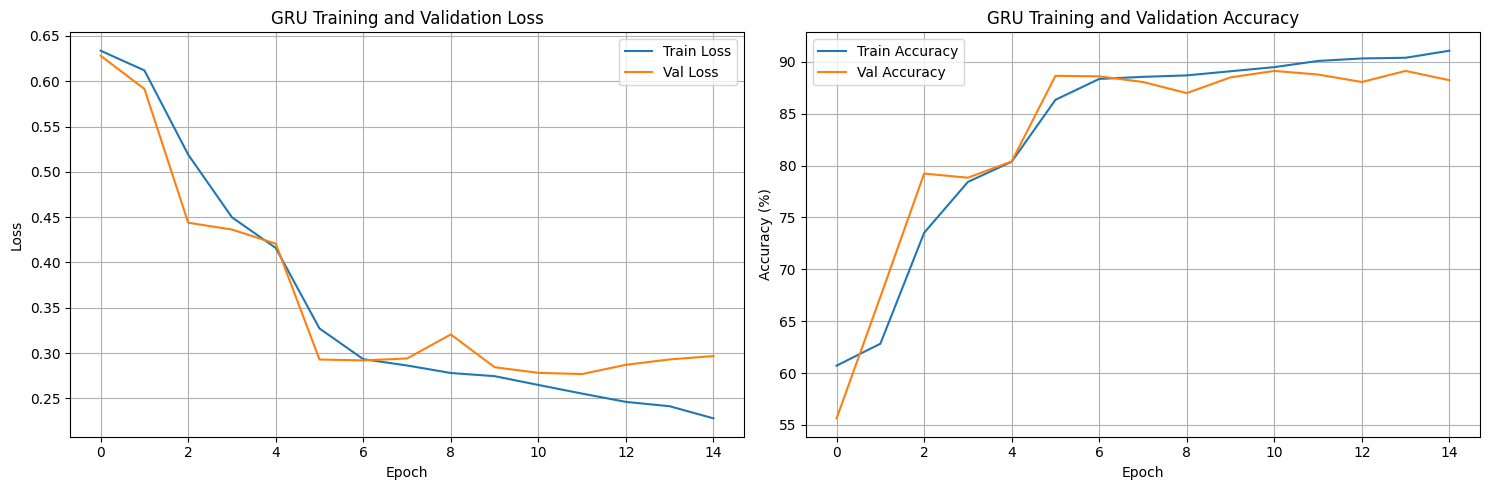

In [ ]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('GRU Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot([acc*100 for acc in train_accs], label='Train Accuracy')
ax2.plot([acc*100 for acc in val_accs], label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('GRU Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.savefig('gru_training_validation.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.tight_layout()
plt.show()

# Model Evaluation

## GRU Evaluation

Evaluating GRU on Test Set


Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]


GRU Test Results:
  Accuracy:  0.8879
  Precision: 0.8501
  Recall:    0.9418
  F1-Score:  0.8936

Detailed Classification Report:
              precision    recall  f1-score   support

       Right       0.93      0.83      0.88      2011
       Wrong       0.85      0.94      0.89      2011

    accuracy                           0.89      4022
   macro avg       0.89      0.89      0.89      4022
weighted avg       0.89      0.89      0.89      4022



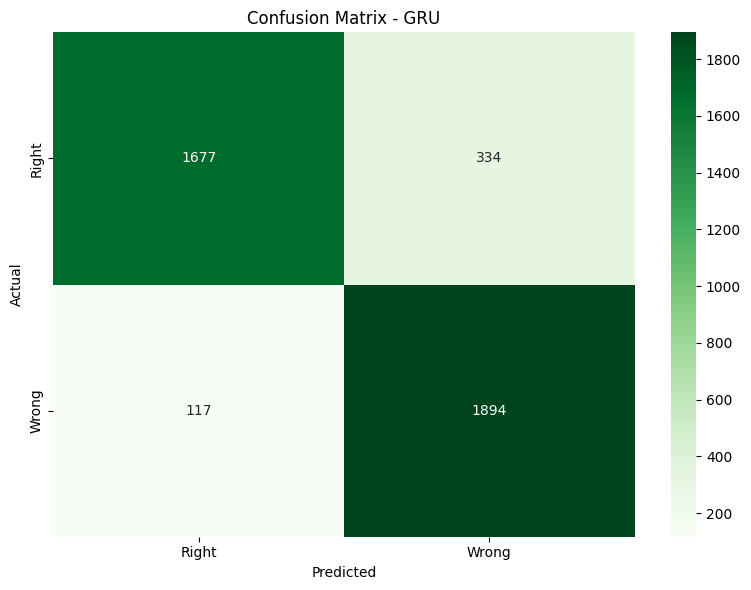

In [ ]:
# Evaluate on test set
print("="*80)
print("Evaluating GRU on Test Set")
print("="*80)

test_loss, test_acc, y_pred_gru, y_true_gru = evaluate_gru(
    gru_model, test_loader, criterion, device
)

# Calculate metrics
test_precision = precision_score(y_true_gru, y_pred_gru)
test_recall = recall_score(y_true_gru, y_pred_gru)
test_f1 = f1_score(y_true_gru, y_pred_gru)

print(f"\nGRU Test Results:")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true_gru, y_pred_gru,
                          target_names=['Right', 'Wrong']))

# Confusion matrix
cm_gru = confusion_matrix(y_true_gru, y_pred_gru)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Greens',
           xticklabels=['Right', 'Wrong'],
           yticklabels=['Right', 'Wrong'])
plt.title('Confusion Matrix - GRU')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('gru_confusion_matrix.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.tight_layout()
plt.show()

In [ ]:
# Save final model state
torch.save(gru_model.state_dict(), 'gru_model.pth')

# Model Testing

In [ ]:
class SentencePredictor:
    """
    Enhanced predictor with caching and interpretability support.

    Improvements:
    - Cache tokens, POS tags, and extracted features to avoid redundant computation
    - Support attention weights and saliency for interpretability
    - Renamed model_type 'lstm' to 'gru' for clarity
    """

    def __init__(self, feature_pipeline_instance, trained_model, scaler, feature_columns, model_type):
        """
        Initialize predictor

        Parameters:
        -----------
        feature_pipeline_instance : FeaturePipeline instance (already initialized with embedding model)
        trained_model : trained model (sklearn or torch.nn.Module)
        scaler : StandardScaler fitted on training data
        feature_columns : list of feature column names
        model_type : 'ml' or 'gru' (formerly 'lstm')
        """
        self.feature_pipeline = feature_pipeline_instance
        self.model = trained_model
        self.scaler = scaler
        self.feature_columns = feature_columns
        self.model_type = model_type

        # Cache for sentence processing
        self._cache = {}

        # If GRU, ensure the model is on the correct device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if self.model_type == 'gru':
            self.model.to(self.device)

    def clear_cache(self):
        """Clear the prediction cache."""
        self._cache.clear()

    def extract_features_for_sentence(self, sentence, use_cache=True):
        """
        Extract all features for a single sentence using the feature pipeline.
        Caches results to avoid redundant computation.

        Parameters:
        -----------
        sentence : str
        use_cache : bool (default True)

        Returns:
        --------
        DataFrame with all features (same format as training data)
        """
        if use_cache and sentence in self._cache:
            return self._cache[sentence]

        # Create a temporary DataFrame for the single sentence
        temp_df = pd.DataFrame({'text': [sentence], 'sentence_correct': [0]})

        # Use the already initialized feature_pipeline to extract features
        processed_df = self.feature_pipeline.extract_all_features(temp_df)

        if use_cache:
            self._cache[sentence] = processed_df

        return processed_df

    def predict_sentence(self, sentence, return_attention=False, return_saliency=False, use_cache=True):
        """
        Predict if a sentence is correct or incorrect.

        Enhanced with attention and saliency support.

        Parameters:
        -----------
        sentence : str
            Khmer sentence to evaluate
        return_attention : bool
            If True and model supports it, return attention weights
        return_saliency : bool
            If True, compute token saliency via gradients
        use_cache : bool
            Use cached features if available

        Returns:
        --------
        dict with prediction, confidence, features, and optionally attention/saliency
        """
        # Extract features using the pipeline (with caching)
        processed_df = self.extract_features_for_sentence(sentence, use_cache=use_cache)
        features_dict = processed_df[self.feature_columns].iloc[0].to_dict()
        tokens = processed_df['tokens'].iloc[0]
        pos_tags = processed_df['pos_tags'].iloc[0]

        prediction_numeric = None
        confidence = None
        prediction_label = None
        attention_weights = None
        saliency_scores = None

        if self.model_type == 'ml':
            # Get feature values for ML model
            X_new = processed_df[self.feature_columns].values
            X_new_scaled = self.scaler.transform(X_new)

            prediction_numeric = self.model.predict(X_new_scaled)[0]

            # Get probability if available
            if hasattr(self.model, 'predict_proba'):
                proba = self.model.predict_proba(X_new_scaled)[0]
                confidence = proba[prediction_numeric]
            else:
                confidence = 1.0

            prediction_label = 'Correct' if prediction_numeric == 0 else 'Incorrect'

        elif self.model_type == 'gru':
            # Prepare data for GRU
            temp_gru_dataset = KhmerTextDataset(
                tokens_list=[tokens],
                labels=[0],  # Dummy label
                embedding_model=self.feature_pipeline.embedding_model,
                use_cache=True  # Use embedding cache
            )
            temp_gru_loader = DataLoader(
                temp_gru_dataset,
                batch_size=1,
                shuffle=False,
                collate_fn=collate_batch
            )

            self.model.eval()

            # Get embeddings for saliency if needed
            if return_saliency:
                embeddings_np = []
                for token in tokens:
                    try:
                        vec = self.feature_pipeline.embedding_model.get_word_vector(token)
                    except:
                        vec = np.zeros(self.feature_pipeline.embedding_model.get_dimension())
                    embeddings_np.append(vec)

                embeddings_for_saliency = torch.FloatTensor(np.array(embeddings_np)).unsqueeze(0).to(self.device)
                embeddings_for_saliency.requires_grad = True
                lengths_for_saliency = torch.LongTensor([len(tokens)]).to(self.device)

            with torch.no_grad():
                for embeddings, labels, lengths in temp_gru_loader:
                    embeddings = embeddings.to(self.device)
                    lengths = lengths.to(self.device)

                    # Check if model has attention (ImprovedGRUClassifier)
                    if hasattr(self.model, 'use_feature_fusion'):
                        outputs, attn_weights = self.model(embeddings, lengths, extra_features=None)
                        if return_attention:
                            attention_weights = attn_weights.cpu().numpy()[0, :len(tokens)]
                    else:
                        outputs = self.model(embeddings, lengths)

                    probabilities = torch.softmax(outputs, dim=1)
                    confidence_tensor, predicted_class_tensor = torch.max(probabilities, 1)

                    prediction_numeric = predicted_class_tensor.item()
                    confidence = confidence_tensor.item()

            # Compute saliency if requested
            if return_saliency:
                try:
                    saliency_scores = compute_token_saliency(
                        self.model,
                        self.feature_pipeline.embedding_model,
                        tokens,
                        prediction_numeric,  # Use predicted label
                        self.device
                    )
                except Exception as e:
                    print(f"Warning: Could not compute saliency: {e}")
                    saliency_scores = None

            prediction_label = 'Correct' if prediction_numeric == 0 else 'Incorrect'

        else:
            raise ValueError(f"Unknown model_type: {self.model_type}")

        result = {
            'sentence': sentence,
            'prediction': prediction_label,
            'prediction_numeric': prediction_numeric,
            'confidence': confidence,
            'features': features_dict,
            'tokens': tokens,
            'pos_tags': pos_tags
        }

        if attention_weights is not None:
            result['attention_weights'] = attention_weights

        if saliency_scores is not None:
            result['saliency_scores'] = saliency_scores

        return result

    def predict_batch(self, sentences, use_cache=True):
        """
        Predict quality for multiple sentences at once

        Parameters:
        -----------
        sentences : list of str
        use_cache : bool

        Returns:
        --------
        DataFrame with predictions
        """
        results = []

        for sentence in tqdm(sentences, desc="Predicting"):
            result = self.predict_sentence(sentence, use_cache=use_cache)
            results.append({
                'sentence': result['sentence'],
                'prediction': result['prediction'],
                'confidence': result['confidence']
            })

        return pd.DataFrame(results)

    def get_attention(self, sentence):
        """
        Get attention weights for a sentence (convenience method).
        Only works if model supports attention.
        """
        result = self.predict_sentence(sentence, return_attention=True, use_cache=True)
        if 'attention_weights' in result:
            return result['tokens'], result['attention_weights']
        else:
            return result['tokens'], None

    def get_saliency(self, sentence):
        """
        Get token saliency for a sentence (convenience method).
        """
        result = self.predict_sentence(sentence, return_saliency=True, use_cache=True)
        if 'saliency_scores' in result:
            return result['tokens'], result['saliency_scores']
        else:
            return result['tokens'], None

In [ ]:
# Load the saved GRU state_dict and prepare the model for prediction
state_dict_path = 'gru_model.pth'

predictor_model_type = 'gru'
best_model_name = 'GRU'

try:
    # Recreate the GRU architecture with the same hyperparameters used during training
    gru_loaded = GRUClassifier(
        EMBEDDING_DIM,
        HIDDEN_DIM,
        OUTPUT_DIM,
        N_LAYERS,
        DROPOUT
    ).to(device)

    # Load state_dict
    state = torch.load(state_dict_path, map_location=device)
    gru_loaded.load_state_dict(state)
    gru_loaded.eval()

    predictor_model = gru_loaded
    print(f"✓ Loaded GRU state_dict from: {state_dict_path}")
except Exception as e:
    predictor_model = None
    print(f"✗ Failed to load GRU state_dict from {state_dict_path}: {e}")

predictor = SentencePredictor(
    feature_pipeline_instance=feature_pipeline,
    trained_model=predictor_model,
    scaler=scaler,
    feature_columns=feature_columns,
    model_type=predictor_model_type  # Now correctly 'gru'
)

print(f"✓ Sentence predictor ready!")
print(f"✓ Using model: {best_model_name} ({predictor_model_type.upper()})")
print(f"\nYou can now use:")
print(f"  - predictor.predict_sentence('your sentence here')")
print(f"  - predictor.get_attention('sentence') # if model supports attention")
print(f"  - predictor.get_saliency('sentence') # for token importance")

✓ Loaded GRU state_dict from: gru_model.pth
✓ Sentence predictor ready!
✓ Using model: GRU (GRU)

You can now use:
  - predictor.predict_sentence('your sentence here')
  - predictor.get_attention('sentence') # if model supports attention
  - predictor.get_saliency('sentence') # for token importance


In [ ]:
test_sentences = [
    {
        'sentence': "កុមារកម្ពុជាទៅសាលារៀននៅព្រឹកនេះ",
        'expected': 'Correct',
        'description': "Correct: Cambodian children go to school this morning (SVO + time)",
        'complexity': 'Mid'
    },
    {
        'sentence': "ខ្ញុំចង់ញ៉ាំបាយនិងបន្លែជាមួយគ្រួសារ",
        'expected': 'Correct',
        'description': "Correct: I want to eat rice and vegetables with family (compound object)",
        'complexity': 'Mid'
    },
    {
        'sentence': "គាត់ធ្វើការក្នុងក្រុមហ៊ុនធំមួយនៅរាជធានីភ្នំពេញ",
        'expected': 'Correct',
        'description': "Correct: He/She works in a big company in Phnom Penh (complex location)",
        'complexity': 'Mid-High'
    },
    {
        'sentence': "សៀវភៅនេះគឺជារបស់របស់ខ្ញុំដែលទិញពីផ្សារ",
        'expected': 'Correct',
        'description': "Correct: This book is mine that I bought from the market (relative clause)",
        'complexity': 'Mid-High'
    },
    {
        'sentence': "នៅទីនេះដើម្បីរៀនភាសាខ្មែរ",
        'expected': 'Incorrect',
        'description': "Incorrect: Missing subject - 'At here to learn Khmer language' (incomplete)",
        'complexity': 'Mid'
    }
]

print(f"Testing {len(test_sentences)} sentences with varying complexity...\n")
print("Model Type: " + best_model_name + " (" + predictor_model_type.upper() + ")")
print("="*80 + "\n")

# Test each sentence
results_detailed = []
correct_predictions = 0

for idx, test_case in enumerate(test_sentences, 1):
    print(f"{'='*80}")
    print(f"TEST {idx}/{len(test_sentences)}")
    print(f"{'='*80}")
    print(f"📝 Sentence: {test_case['sentence']}")
    print(f"📋 Description: {test_case['description']}")
    print(f"⚙️  Complexity: {test_case['complexity']}")
    print(f"✓ Expected: {test_case['expected']}")
    print()

    # Get prediction
    result = predictor.predict_sentence(test_case['sentence'])

    # Display results
    print(f"🤖 PREDICTION RESULTS:")
    print(f"   Prediction: {result['prediction']}")
    print(f"   Confidence: {result['confidence']:.2%}")
    print(f"   Status: {'✅ CORRECT' if result['prediction'] == test_case['expected'] else '❌ WRONG'}")

    # Show key features
    print(f"\n📊 Key Feature Values:")
    print(f"   dep_grammar_score:        {result['features']['dep_grammar_score']:.3f}")
    print(f"   has_complete_clause:      {result['features']['has_complete_clause']}")
    print(f"   oov_ratio:                {result['features']['oov_ratio']:.3f}")
    print(f"   semantic_coherence:       {result['features']['semantic_coherence']:.3f}")
    print(f"   grammar_oov_interaction:  {result['features']['grammar_oov_interaction']:.3f}")

    # Show tokenization
    print(f"\n🔤 Tokens ({len(result['tokens'])} words):")
    print(f"   {' | '.join(result['tokens'])}")

    print(f"\n🏷️  POS Tags:")
    print(f"   {' | '.join(result['pos_tags'])}")

    print()

    # Track accuracy
    if result['prediction'] == test_case['expected']:
        correct_predictions += 1

    # Store for summary
    results_detailed.append({
        'sentence': test_case['sentence'],
        'expected': test_case['expected'],
        'predicted': result['prediction'],
        'confidence': result['confidence'],
        'correct': result['prediction'] == test_case['expected'],
        'grammar_score': result['features']['dep_grammar_score'],
        'oov_ratio': result['features']['oov_ratio']
    })

# Summary statistics
print("\n" + "="*80)
print("TESTING SUMMARY")
print("="*80)
print(f"\n📈 Overall Accuracy: {correct_predictions}/{len(test_sentences)} ({correct_predictions/len(test_sentences)*100:.1f}%)")
print(f"✅ Correct Predictions: {correct_predictions}")
print(f"❌ Wrong Predictions: {len(test_sentences) - correct_predictions}")
print(f"\n🎯 Average Confidence: {np.mean([r['confidence'] for r in results_detailed]):.2%}")

# Create summary table
summary_df = pd.DataFrame(results_detailed)
print(f"\n📊 Detailed Results Table:")
print("="*80)
print(summary_df.to_string(index=False))

Testing 5 sentences with varying complexity...

Model Type: GRU (GRU)

TEST 1/5
📝 Sentence: កុមារកម្ពុជាទៅសាលារៀននៅព្រឹកនេះ
📋 Description: Correct: Cambodian children go to school this morning (SVO + time)
⚙️  Complexity: Mid
✓ Expected: Correct

Loading POS tagger: seanghay/khmer-pos-roberta...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Device set to use cuda:0


✓ POS tagger loaded successfully
Tagging 1 sentences...


POS Tagging:   0%|          | 0/1 [00:00<?, ?it/s]

✓ POS tagging complete
✓ Added 'tokens' column
✓ Added 'pos_tags' column
Calculating OOV features for 1 texts...


OOV Analysis:   0%|          | 0/1 [00:00<?, ?it/s]


✓ OOV features extracted
  Mean OOV ratio: 0.000
  Mean vocab coverage: 1.000
  Median OOV ratio: 0.000
  Max OOV ratio: 0.000
Extracting simple POS-based grammar features...
✓ Simple grammar features extracted
  Mean grammar score: 1.000
  Complete clauses: 1 / 1 (100.0%)
Calculating text features...
✓ Text features extracted (including POS diversity)
Calculating semantic coherence features (vectorized)...


Semantic Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Semantic coherence extracted
  Mean coherence: 0.238
✓ Interaction features extracted
Caching embeddings for 8 new unique tokens...
✓ Total cached tokens: 214
🤖 PREDICTION RESULTS:
   Prediction: Correct
   Confidence: 98.02%
   Status: ✅ CORRECT

📊 Key Feature Values:
   dep_grammar_score:        1.000
   has_complete_clause:      1.0
   oov_ratio:                0.000
   semantic_coherence:       0.238
   grammar_oov_interaction:  1.000

🔤 Tokens (8 words):
   កុមារ | កម្ពុជា | ទៅ | សាលា | រៀន | នៅ | ព្រឹក | នេះ

🏷️  POS Tags:
   NN | PN | VB | NN | VB | IN | NN | DT

TEST 2/5
📝 Sentence: ខ្ញុំចង់ញ៉ាំបាយនិងបន្លែជាមួយគ្រួសារ
📋 Description: Correct: I want to eat rice and vegetables with family (compound object)
⚙️  Complexity: Mid
✓ Expected: Correct

Tagging 1 sentences...


POS Tagging:   0%|          | 0/1 [00:00<?, ?it/s]

✓ POS tagging complete
✓ Added 'tokens' column
✓ Added 'pos_tags' column
Calculating OOV features for 1 texts...


OOV Analysis:   0%|          | 0/1 [00:00<?, ?it/s]


✓ OOV features extracted
  Mean OOV ratio: 0.143
  Mean vocab coverage: 0.857
  Median OOV ratio: 0.143
  Max OOV ratio: 0.143
Extracting simple POS-based grammar features...
✓ Simple grammar features extracted
  Mean grammar score: 1.000
  Complete clauses: 1 / 1 (100.0%)
Calculating text features...
✓ Text features extracted (including POS diversity)
Calculating semantic coherence features (vectorized)...


Semantic Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Semantic coherence extracted
  Mean coherence: 0.233
✓ Interaction features extracted
Caching embeddings for 7 new unique tokens...
✓ Total cached tokens: 221
🤖 PREDICTION RESULTS:
   Prediction: Correct
   Confidence: 98.88%
   Status: ✅ CORRECT

📊 Key Feature Values:
   dep_grammar_score:        1.000
   has_complete_clause:      1.0
   oov_ratio:                0.143
   semantic_coherence:       0.233
   grammar_oov_interaction:  0.857

🔤 Tokens (7 words):
   ខ្ញុំ | ចង់ញ៉ាំ | បាយ | និង | បន្លែ | ជាមួយ | គ្រួសារ

🏷️  POS Tags:
   PRO | VB | NN | CC | NN | IN | NN

TEST 3/5
📝 Sentence: គាត់ធ្វើការក្នុងក្រុមហ៊ុនធំមួយនៅរាជធានីភ្នំពេញ
📋 Description: Correct: He/She works in a big company in Phnom Penh (complex location)
⚙️  Complexity: Mid-High
✓ Expected: Correct

Tagging 1 sentences...


POS Tagging:   0%|          | 0/1 [00:00<?, ?it/s]

✓ POS tagging complete
✓ Added 'tokens' column
✓ Added 'pos_tags' column
Calculating OOV features for 1 texts...


OOV Analysis:   0%|          | 0/1 [00:00<?, ?it/s]


✓ OOV features extracted
  Mean OOV ratio: 0.125
  Mean vocab coverage: 0.875
  Median OOV ratio: 0.125
  Max OOV ratio: 0.125
Extracting simple POS-based grammar features...
✓ Simple grammar features extracted
  Mean grammar score: 0.800
  Complete clauses: 1 / 1 (100.0%)
Calculating text features...
✓ Text features extracted (including POS diversity)
Calculating semantic coherence features (vectorized)...


Semantic Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Semantic coherence extracted
  Mean coherence: 0.240
✓ Interaction features extracted
Caching embeddings for 7 new unique tokens...
✓ Total cached tokens: 228
🤖 PREDICTION RESULTS:
   Prediction: Correct
   Confidence: 96.75%
   Status: ✅ CORRECT

📊 Key Feature Values:
   dep_grammar_score:        0.800
   has_complete_clause:      1.0
   oov_ratio:                0.125
   semantic_coherence:       0.240
   grammar_oov_interaction:  0.700

🔤 Tokens (8 words):
   គាត់ | ធ្វើការ | ក្នុង | ក្រុមហ៊ុន | ធំ | មួយ | នៅ | រាជធានីភ្នំពេញ

🏷️  POS Tags:
   PRO | VB | IN | NN | JJ | DT | IN | PN

TEST 4/5
📝 Sentence: សៀវភៅនេះគឺជារបស់របស់ខ្ញុំដែលទិញពីផ្សារ
📋 Description: Correct: This book is mine that I bought from the market (relative clause)
⚙️  Complexity: Mid-High
✓ Expected: Correct

Tagging 1 sentences...


POS Tagging:   0%|          | 0/1 [00:00<?, ?it/s]

✓ POS tagging complete
✓ Added 'tokens' column
✓ Added 'pos_tags' column
Calculating OOV features for 1 texts...


OOV Analysis:   0%|          | 0/1 [00:00<?, ?it/s]


✓ OOV features extracted
  Mean OOV ratio: 0.000
  Mean vocab coverage: 1.000
  Median OOV ratio: 0.000
  Max OOV ratio: 0.000
Extracting simple POS-based grammar features...
✓ Simple grammar features extracted
  Mean grammar score: 1.000
  Complete clauses: 1 / 1 (100.0%)
Calculating text features...
✓ Text features extracted (including POS diversity)
Calculating semantic coherence features (vectorized)...


Semantic Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Semantic coherence extracted
  Mean coherence: 0.350
✓ Interaction features extracted
Caching embeddings for 7 new unique tokens...
✓ Total cached tokens: 235
🤖 PREDICTION RESULTS:
   Prediction: Correct
   Confidence: 98.36%
   Status: ✅ CORRECT

📊 Key Feature Values:
   dep_grammar_score:        1.000
   has_complete_clause:      1.0
   oov_ratio:                0.000
   semantic_coherence:       0.350
   grammar_oov_interaction:  1.000

🔤 Tokens (10 words):
   សៀវភៅ | នេះ | គឺជា | របស់ | របស់ | ខ្ញុំ | ដែល | ទិញ | ពី | ផ្សារ

🏷️  POS Tags:
   NN | DT | VB | NN | IN | PRO | RPN | VB | IN | NN

TEST 5/5
📝 Sentence: នៅទីនេះដើម្បីរៀនភាសាខ្មែរ
📋 Description: Incorrect: Missing subject - 'At here to learn Khmer language' (incomplete)
⚙️  Complexity: Mid
✓ Expected: Incorrect

Tagging 1 sentences...


POS Tagging:   0%|          | 0/1 [00:00<?, ?it/s]

✓ POS tagging complete
✓ Added 'tokens' column
✓ Added 'pos_tags' column
Calculating OOV features for 1 texts...


OOV Analysis:   0%|          | 0/1 [00:00<?, ?it/s]


✓ OOV features extracted
  Mean OOV ratio: 0.000
  Mean vocab coverage: 1.000
  Median OOV ratio: 0.000
  Max OOV ratio: 0.000
Extracting simple POS-based grammar features...
✓ Simple grammar features extracted
  Mean grammar score: 1.000
  Complete clauses: 1 / 1 (100.0%)
Calculating text features...
✓ Text features extracted (including POS diversity)
Calculating semantic coherence features (vectorized)...


Semantic Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Semantic coherence extracted
  Mean coherence: 0.318
✓ Interaction features extracted
Caching embeddings for 4 new unique tokens...
✓ Total cached tokens: 239
🤖 PREDICTION RESULTS:
   Prediction: Correct
   Confidence: 88.69%
   Status: ❌ WRONG

📊 Key Feature Values:
   dep_grammar_score:        1.000
   has_complete_clause:      1.0
   oov_ratio:                0.000
   semantic_coherence:       0.318
   grammar_oov_interaction:  1.000

🔤 Tokens (7 words):
   នៅ | ទី | នេះ | ដើម្បី | រៀន | ភាសា | ខ្មែរ

🏷️  POS Tags:
   IN | NN | DT | IN | VB | NN | PN


TESTING SUMMARY

📈 Overall Accuracy: 4/5 (80.0%)
✅ Correct Predictions: 4
❌ Wrong Predictions: 1

🎯 Average Confidence: 96.14%

📊 Detailed Results Table:
                                      sentence  expected predicted  confidence  correct  grammar_score  oov_ratio
               កុមារកម្ពុជាទៅសាលារៀននៅព្រឹកនេះ   Correct   Correct    0.980221     True            1.0   0.000000
           ខ្ញុំចង់ញ៉ាំបាយនិងបន្លែជាមួយគ្រួសារ   Corre